# Processing Pipelines

You've already written this plenty of times by now: pass a string of text to the nlp object, and receive a Doc object.

But what does the nlp object actually do?

First, the tokenizer is applied to turn the string of text into a Doc object. Next, a series of pipeline components is applied to the doc in order. In this case, the tagger, then the parser, then the entity recognizer. Finally, the processed doc is returned, so you can work with it.

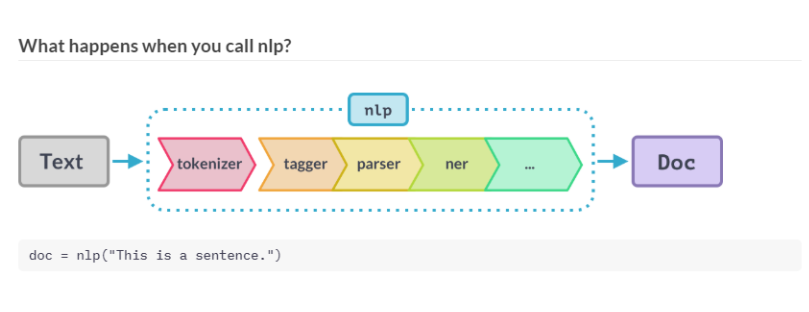

spaCy ships with the following built-in pipeline components.

The part-of-speech tagger sets the token.tag and token.pos attributes.

The dependency parser adds the token.dep and token.head attributes and is also responsible for detecting sentences and base noun phrases, also known as noun chunks.

The named entity recognizer adds the detected entities to the doc.ents property. It also sets entity type attributes on the tokens that indicate if a token is part of an entity or not.

Finally, the text classifier sets category labels that apply to the whole text, and adds them to the doc.cats property.

Because text categories are always very specific, the text classifier is not included in any of the pre-trained models by default. But you can use it to train your own system.

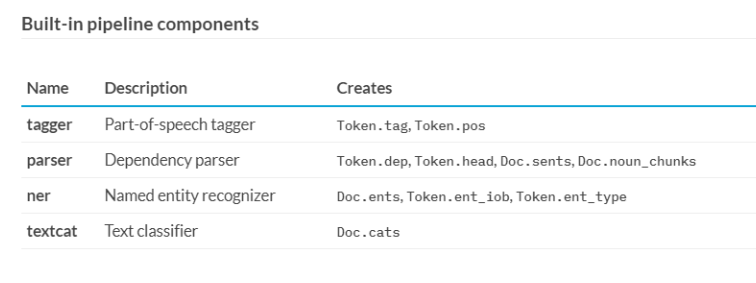

All models you can load into spaCy include several files and a meta.json.

The meta defines things like the language and pipeline. This tells spaCy which components to instantiate.

The built-in components that make predictions also need binary data. The data is included in the model package and loaded into the component when you load the model.

In [1]:
import spacy

nlp = spacy.load("en_core_web_sm")

doc = 'This is new thing in India'

obj = nlp(doc)

In [2]:
nlp.pipe_names

['tagger', 'parser', 'ner']

In [3]:
nlp.pipeline

[('tagger', <spacy.pipeline.pipes.Tagger at 0x1e5bb553848>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x1e5bb5563a8>),
 ('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x1e5bb556948>)]

That's correct! The tokenizer turns a string of text into a Doc object. spaCy then applies every component in the pipeline on document, in order.

# Custom Pipeline

After the text is tokenized and a Doc object has been created, pipeline components are applied in order. spaCy supports a range of built-in components, but also lets you define your own.

Custom components are executed automatically when you call the nlp object on a text.

They're especially useful for adding your own custom metadata to documents and tokens.

You can also use them to update built-in attributes, like the named entity spans.

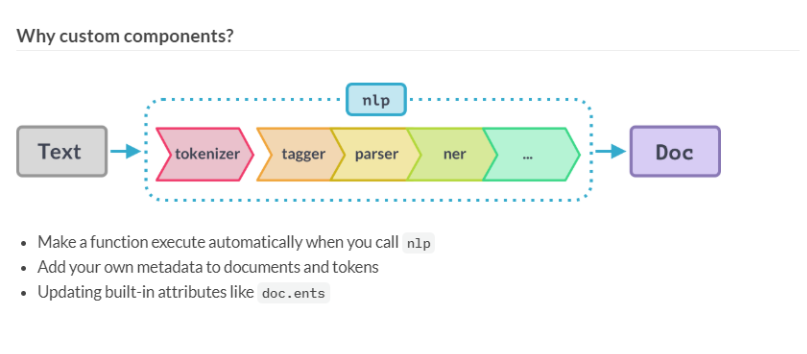

# Adding Custom Component to Pipeline

Fundamentally, a pipeline component is a function or callable that takes a doc, modifies it and returns it, so it can be processed by the next component in the pipeline.

Components can be added to the pipeline using the nlp.add_pipe. The method takes at least one argument: the component function.

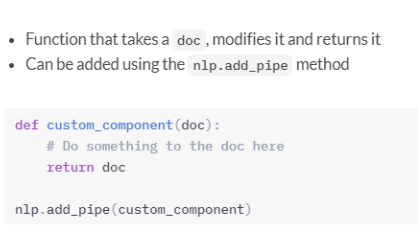

# Where to Add the Pipeline Component

To specify where to add the component in the pipeline, you can use the following keyword arguments:

Setting last to True will add the component last in the pipeline. This is the default behavior.

Setting first to True will add the component first in the pipeline, right after the tokenizer.

The before and after arguments let you define the name of an existing component to add the new component before or after. For example, before="ner" will add it before the named entity recognizer.

The other component to add the new component before or after needs to exist, though – otherwise, spaCy will raise an error.

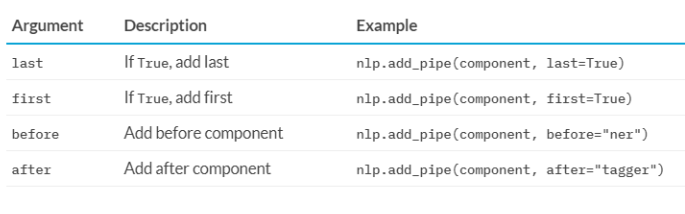


In [4]:
# Example: A Single Component
# Create the nlp object
nlp = spacy.load("en_core_web_sm")

# Define a custom component
def custom_component(doc):
    # Print the doc's length
    print("Doc length:", len(doc))
    # Return the doc object
    return doc

# Add the component first in the pipeline
nlp.add_pipe(custom_component, first=True)

# Print the pipeline component names
print("Pipeline:", nlp.pipe_names)

Pipeline: ['custom_component', 'tagger', 'parser', 'ner']


In [5]:
# Create the nlp object
nlp = spacy.load("en_core_web_sm")

# Define a custom component
def custom_component(doc):

    # Print the doc's length
    print("Doc length:", len(doc))

    # Return the doc object
    return doc

# Add the component first in the pipeline
nlp.add_pipe(custom_component, first=True)

# Process a text
doc = nlp("Hello world!")

Doc length: 3


In [6]:
import spacy
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span

nlp = spacy.load("en_core_web_sm")
animals = ["Golden Retriever", "cat", "turtle", "Rattus norvegicus"]
animal_patterns = list(nlp.pipe(animals))
print("animal_patterns:", animal_patterns)
matcher = PhraseMatcher(nlp.vocab)
matcher.add("ANIMAL", None, *animal_patterns)

# Define the custom component
def animal_component(doc):
    # Apply the matcher to the doc
    matches = matcher(doc)
    # Create a Span for each match and assign the label "ANIMAL"
    spans = [Span(doc, start, end, label="ANIMAL") for match_id, start, end in matches]
    # Overwrite the doc.ents with the matched spans
    doc.ents = spans
    return doc


# Add the component to the pipeline after the "ner" component
nlp.add_pipe(animal_component, after="ner")
print(nlp.pipe_names)

# Process the text and print the text and label for the doc.ents
doc = nlp("I have a cat and a Golden Retriever")
print([(ent.text, ent.label_) for ent in doc.ents])

animal_patterns: [Golden Retriever, cat, turtle, Rattus norvegicus]
['tagger', 'parser', 'ner', 'animal_component']
[('cat', 'ANIMAL'), ('Golden Retriever', 'ANIMAL')]


# Extension Attributes

Custom attributes let you add any meta data to docs, tokens and spans. The data can be added once, or it can be computed dynamically.

Custom attributes are available via the ._ (dot underscore) property. This makes it clear that they were added by the user, and not built into spaCy, like token.text.

Attributes need to be registered on the global Doc, Token and Span classes you can import from spacy.tokens. You've already worked with those in the previous chapters. To register a custom attribute on the Doc, Token and Span, you can use the set_extension method.

The first argument is the attribute name. Keyword arguments let you define how the value should be computed. In this case, it has a default value and can be overwritten.

There are three types of extensions: 

1) attribute extensions, 

2) property extensions and 

3) method extensions.

In [8]:
# Import global classes
from spacy.tokens import Doc, Token, Span

# Set extensions on the Doc, Token and Span
Doc.set_extension("title", default=None)
Token.set_extension("is_color", default=False)
Span.set_extension("has_color", default=False)

In [9]:
doc._.title = "My document"
token._.is_color = True
span._.has_color = False

NameError: name 'token' is not defined

In [11]:
# Attribute Extension

from spacy.tokens import Token

# Set extension on the Token with default value
Token.set_extension("is_color", default=False,force=True)

doc = nlp("The sky is blue.")

# Overwrite extension attribute value
doc[3]._.is_color = True

# Property Extensions
Property extensions work like properties in Python: they can define a getter function and an optional setter.

The getter function is only called when you retrieve the attribute. This lets you compute the value dynamically, and even take other custom attributes into account.

Getter functions take one argument: the object, in this case, the token. In this example, the function returns whether the token text is in our list of colors.

We can then provide the function via the getter keyword argument when we register the extension.

The token "blue" now returns True for ._.is_color.

In [13]:
# Property Extensions
from spacy.tokens import Token

# Define getter function
def get_is_color(token):
    colors = ["red", "yellow", "blue"]
    return token.text in colors

# Set extension on the Token with getter
Token.set_extension("is_color", getter=get_is_color, force=True)

doc = nlp("The sky is blue.")
print(doc[3]._.is_color, "-", doc[3].text)

True - blue


# Property Extensions on Span

If you want to set extension attributes on a span, you almost always want to use a property extension with a getter. Otherwise, you'd have to update every possible span ever by hand to set all the values.

In this example, the get_has_color function takes the span and returns whether the text of any of the tokens is in the list of colors.

After we've processed the doc, we can check different slices of the doc and the custom ._.has_color property returns whether the span contains a color token or not.

In [15]:
from spacy.tokens import Span

# Define getter function
def get_has_color(span):
    colors = ["red", "yellow", "blue"]
    return any(token.text in colors for token in span)

# Set extension on the Span with getter
Span.set_extension("has_color", getter=get_has_color, force =True)

doc = nlp("The sky is blue.")
print(doc[1:4]._.has_color, "-", doc[1:4].text)
print(doc[0:2]._.has_color, "-", doc[0:2].text)

True - sky is blue
False - The sky


# Method extensions make the extension attribute a callable method.

You can then pass one or more arguments to it, and compute attribute values dynamically – for example, based on a certain argument or setting.

In this example, the method function checks whether the doc contains a token with a given text. The first argument of the method is always the object itself – in this case, the doc. It's passed in automatically when the method is called. All other function arguments will be arguments on the method extension. In this case, token_text.

Here, the custom ._.has_token method returns True for the word "blue" and False for the word "cloud".

In [16]:
from spacy.tokens import Doc

# Define method with arguments
def has_token(doc, token_text):
    in_doc = token_text in [token.text for token in doc]
    return in_doc

# Set extension on the Doc with method
Doc.set_extension("has_token", method=has_token)

doc = nlp("The sky is blue.")
print(doc._.has_token("blue"), "- blue")
print(doc._.has_token("cloud"), "- cloud")

True - blue
False - cloud


In [17]:
from spacy.lang.en import English
from spacy.tokens import Token

nlp = English()

# Register the Token extension attribute "is_country" with the default value False
Token.set_extension("is_country", default=False)

# Process the text and set the is_country attribute to True for the token "Spain"
doc = nlp("I live in Spain.")
doc[3]._.is_country = True

# Print the token text and the is_country attribute for all tokens
print([(token.text, token._.is_country) for token in doc])

[('I', False), ('live', False), ('in', False), ('Spain', True), ('.', False)]


In [18]:
from spacy.lang.en import English
from spacy.tokens import Token

nlp = English()

# Define the getter function that takes a token and returns its reversed text
def get_reversed(token):
    return token.text[::-1]


# Register the Token property extension "reversed" with the getter get_reversed
Token.set_extension("reversed", getter=get_reversed)

# Process the text and print the reversed attribute for each token
doc = nlp("All generalizations are false, including this one.")
for token in doc:
    print("reversed:", token._.reversed)

reversed: llA
reversed: snoitazilareneg
reversed: era
reversed: eslaf
reversed: ,
reversed: gnidulcni
reversed: siht
reversed: eno
reversed: .


In [19]:
from spacy.lang.en import English
from spacy.tokens import Doc

nlp = English()

# Define the getter function
def get_has_number(doc):
    # Return if any of the tokens in the doc return True for token.like_num
    return any(token.like_num for token in doc)

# Register the Doc property extension "has_number" with the getter get_has_number
Doc.set_extension("has_number", getter=get_has_number)

# Process the text and check the custom has_number attribute
doc = nlp("The museum closed for five years in 2012.")
print("has_number:", doc._.has_number)

has_number: True


In [20]:
from spacy.lang.en import English
from spacy.tokens import Span

nlp = English()

# Define the method
def to_html(span, tag):
    # Wrap the span text in a HTML tag and return it
    return f"<{tag}>{span.text}</{tag}>"


# Register the Span property extension "to_html" with the method to_html
Span.set_extension("to_html", method=to_html)

# Process the text and call the to_html method on the span with the tag name "strong"
doc = nlp("Hello world, this is a sentence.")
span = doc[0:2]
print(span._.to_html("strong"))

<strong>Hello world</strong>


In [24]:
import spacy
from spacy.tokens import Span

nlp = spacy.load("en_core_web_sm")


def get_wikipedia_url(span):
    # Get a Wikipedia URL if the span has one of the labels
    if span.label_ in ("PERSON", "ORG", "GPE", "LOCATION"):
        entity_text = span.text.replace(" ", "_")
        return "https://en.wikipedia.org/w/index.php?search=" + entity_text


# Set the Span extension wikipedia_url using get getter get_wikipedia_url
Span.set_extension("wikipedia_url", getter=get_wikipedia_url, force=True)

doc = nlp(
    "In over fifty years from his very first recordings right through to his "
    "last album, David Bowie and Charles Brown in Australia was at the vanguard of contemporary culture."
)
for ent in doc.ents:
    # Print the text and Wikipedia URL of the entity
    print(ent.text, ent._.wikipedia_url)

fifty years None
David Bowie https://en.wikipedia.org/w/index.php?search=David_Bowie
Charles Brown https://en.wikipedia.org/w/index.php?search=Charles_Brown
Australia https://en.wikipedia.org/w/index.php?search=Australia


# Extension attributes 
are especially powerful if they’re combined with custom pipeline components. In this exercise, you’ll write a pipeline component that finds country names and a custom extension attribute that returns a country’s capital, if available.

In [25]:
import json
from spacy.lang.en import English
from spacy.tokens import Span
from spacy.matcher import PhraseMatcher

with open("countries.json") as f:
    COUNTRIES = json.loads(f.read())

with open("capitals.json") as f:
    CAPITALS = json.loads(f.read())

nlp = English()
matcher = PhraseMatcher(nlp.vocab)
matcher.add("COUNTRY", None, *list(nlp.pipe(COUNTRIES)))


def countries_component(doc):
    # Create an entity Span with the label "GPE" for all matches
    matches = matcher(doc)
    doc.ents = [Span(doc, start, end, label="GPE") for match_id, start, end in matches]
    return doc


# Add the component to the pipeline
nlp.add_pipe(countries_component)
print(nlp.pipe_names)

# Getter that looks up the span text in the dictionary of country capitals
get_capital = lambda span: CAPITALS.get(span.text)

# Register the Span extension attribute "capital" with the getter get_capital
Span.set_extension("capital", getter=get_capital)

# Process the text and print the entity text, label and capital attributes
doc = nlp("Czech Republic may help Slovakia protect its airspace")
print([(ent.text, ent.label_, ent._.capital) for ent in doc.ents])

['countries_component']
[('Czech Republic', 'GPE', 'Prague'), ('Slovakia', 'GPE', 'Bratislava')]


# Scaling and Performance

If you need to process a lot of texts and create a lot of Doc objects in a row, the nlp.pipe method can speed this up significantly.

It processes the texts as a stream and yields Doc objects.

It is much faster than just calling nlp on each text, because it batches up the texts.

nlp.pipe is a generator that yields Doc objects, so in order to get a list of docs, remember to call the list method around it.

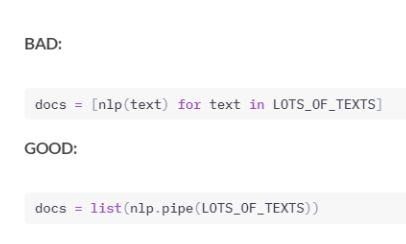

# Passing Context

nlp.pipe also supports passing in tuples of text / context if you set as_tuples to True.

The method will then yield doc / context tuples.

This is useful for passing in additional metadata, like an ID associated with the text, or a page number.

In [26]:
data = [
    ("This is a text", {"id": 1, "page_number": 15}),
    ("And another text", {"id": 2, "page_number": 16}),
]

for doc, context in nlp.pipe(data, as_tuples=True):
    print(doc.text, context["page_number"])

This is a text 15
And another text 16


You can even add the context meta data to custom attributes.

In this example, we're registering two extensions, id and page number, which default to None.

After processing the text and passing through the context, we can overwrite the doc extensions with our context metadata.

In [27]:
from spacy.tokens import Doc

Doc.set_extension("id", default=None)
Doc.set_extension("page_number", default=None)

data = [
    ("This is a text", {"id": 1, "page_number": 15}),
    ("And another text", {"id": 2, "page_number": 16}),
]

for doc, context in nlp.pipe(data, as_tuples=True):
    doc._.id = context["id"]
    doc._.page_number = context["page_number"]

# Using Only Tokenizer

Another common scenario: Sometimes you already have a model loaded to do other processing, but you only need the tokenizer for one particular text.

Running the whole pipeline is unnecessarily slow, because you'll be getting a bunch of predictions from the model that you don't need.

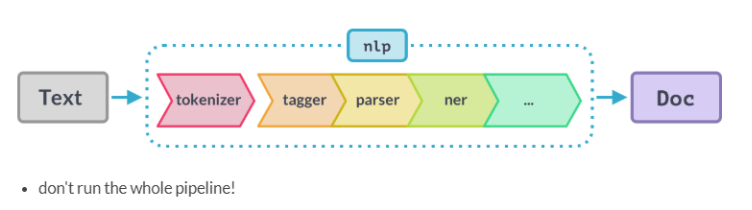

If you only need a tokenized Doc object, you can use the nlp.make_doc method instead, which takes a text and returns a doc.

This is also how spaCy does it behind the scenes: nlp.make_doc turns the text into a doc before the pipeline components are called.

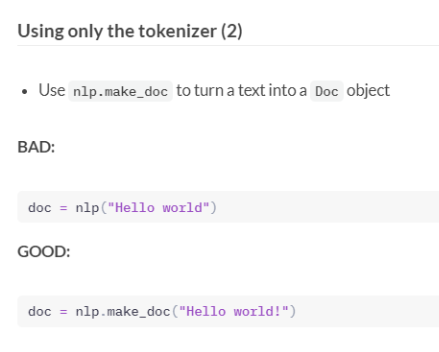


# Disabling Pipeline Components

spaCy also allows you to temporarily disable pipeline components using the nlp.disable_pipes context manager.

It takes a variable number of arguments, the string names of the pipeline components to disable. For example, if you only want to use the entity recognizer to process a document, you can temporarily disable the tagger and parser.

After the with block, the disabled pipeline components are automatically restored.

In the with block, spaCy will only run the remaining components.

In [ ]:
# Disable tagger and parser
with nlp.disable_pipes("tagger", "parser"):
    # Process the text and print the entities
    doc = nlp(text)
    print(doc.ents)

In [28]:
import json
import spacy

nlp = spacy.load("en_core_web_sm")

with open("tweets.json") as f:
    TEXTS = json.loads(f.read())

# Process the texts and print the adjectives
for text in TEXTS:
    doc = nlp(text)
    print([token.text for token in doc if token.pos_ == "ADJ"])

['favorite']
['sick']
[]
['happy']
['delicious', 'fast']
[]
['terrible']


In [30]:
# Rewrite above using pipeline
import json
import spacy

nlp = spacy.load("en_core_web_sm")

with open("tweets.json") as f:
    TEXTS = json.loads(f.read())

# Process the texts and print the entities
docs = [nlp(text) for text in TEXTS]
entities = [doc.ents for doc in docs]
print(*entities)

(McDonalds,) () (McDonalds,) (McDonalds, Spain) (The Arch Deluxe,) () (This morning, gettin mcdonalds)


In [31]:
from spacy.lang.en import English

nlp = English()

people = ["David Bowie", "Angela Merkel", "Lady Gaga"]

# Create a list of patterns for the PhraseMatcher
patterns = [nlp(person) for person in people]

In [32]:
import json
from spacy.lang.en import English
from spacy.tokens import Doc

with open("bookquotes.json") as f:
    DATA = json.loads(f.read())

nlp = English()

# Register the Doc extension "author" (default None)
Doc.set_extension("author", default=None)

# Register the Doc extension "book" (default None)
Doc.set_extension("book", default=None)

for doc, context in nlp.pipe(DATA, as_tuples=True):
    # Set the doc._.book and doc._.author attributes from the context
    doc._.book = context["book"]
    doc._.author = context["author"]

    # Print the text and custom attribute data
    print(f"{doc.text}\n — '{doc._.book}' by {doc._.author}\n")

One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin.
 — 'Metamorphosis' by Franz Kafka

I know not all that may be coming, but be it what it will, I'll go to it laughing.
 — 'Moby-Dick or, The Whale' by Herman Melville

It was the best of times, it was the worst of times.
 — 'A Tale of Two Cities' by Charles Dickens

The only people for me are the mad ones, the ones who are mad to live, mad to talk, mad to be saved, desirous of everything at the same time, the ones who never yawn or say a commonplace thing, but burn, burn, burn like fabulous yellow roman candles exploding like spiders across the stars.
 — 'On the Road' by Jack Kerouac

It was a bright cold day in April, and the clocks were striking thirteen.
 — '1984' by George Orwell

Nowadays people know the price of everything and the value of nothing.
 — 'The Picture Of Dorian Gray' by Oscar Wilde



In [34]:
import spacy

nlp = spacy.load("en_core_web_sm")
text = (
    "Chick-fil-A is an American fast food restaurant chain headquartered in "
    "the city of College Park, Georgia, specializing in chicken sandwiches."
)

# Only tokenize the text
doc = nlp(text)
print([token.text for token in doc])

['Chick', '-', 'fil', '-', 'A', 'is', 'an', 'American', 'fast', 'food', 'restaurant', 'chain', 'headquartered', 'in', 'the', 'city', 'of', 'College', 'Park', ',', 'Georgia', ',', 'specializing', 'in', 'chicken', 'sandwiches', '.']


In [39]:
import spacy

nlp = spacy.load("en_core_web_sm")
text = (
    "Chick-fil-A is an American fast food restaurant chain headquartered in "
    "the city of College Park, Georgia, specializing in chicken sandwiches."
)

# Disable the tagger and parser
with nlp.disable_pipes("tagger", "parser"):
    # Process the text
    doc = nlp(text)
    # Print the entities in the doc
    print(doc.ents)

(American, College Park, Georgia)


In [38]:
dir(doc)

['_',
 '__bytes__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '_bulk_merge',
 '_py_tokens',
 '_realloc',
 '_vector',
 '_vector_norm',
 'cats',
 'char_span',
 'count_by',
 'doc',
 'ents',
 'extend_tensor',
 'from_array',
 'from_bytes',
 'from_disk',
 'get_extension',
 'get_lca_matrix',
 'has_extension',
 'has_vector',
 'is_nered',
 'is_parsed',
 'is_sentenced',
 'is_tagged',
 'lang',
 'lang_',
 'mem',
 'merge',
 'noun_chunks',
 'noun_chunks_iterator',
 'print_tree',
 'remove_extension',
 'retokenize',
 'sentiment',
 'sents',
 'set_extension',
 'similarity',
 'tensor',
 'text',
 'text_with_ws',
 'to_array',
 'to_byte